## Generating Accessibility Vars

Arezoo Besharati, UrbanSim, July 2018 


In [1]:
import os; os.chdir('../')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import orca
import warnings;
warnings.simplefilter('ignore')

### Load data

In [2]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [3]:
# get a list of all existing tables
orca.list_tables()

['parcels', 'buildings', 'rentals', 'units', 'households', 'persons', 'jobs']

### Generate Node variables

In [4]:
orca.run(['initialize_network'])

Running step 'initialize_network'
Time to execute step 'initialize_network': 19.18 s
Total time to execute iteration 1 with iteration value None: 19.18 s


In [5]:
orca.run(['network_aggregations'])

Running step 'network_aggregations'
Computing accessibility variables
Computing residential_units_500
Removed 4 rows because they contain missing values
Computing residential_units_1500
Removed 4 rows because they contain missing values
Computing population_1500
Removed 189769 rows because they contain missing values
Computing poor_1500
Removed 53114 rows because they contain missing values
Computing renters_1500
Removed 102597 rows because they contain missing values
Computing med_income_1500
Removed 189769 rows because they contain missing values
Computing job_1500
Computing job_25km
Computing ave_hhsize
Removed 189769 rows because they contain missing values
Computing med_rent_sqft_1500
Computing med_rent_sqft_7000
       residential_units_500  residential_units_1500  population_1500  \
count           30826.000000            30826.000000     30826.000000   
mean                4.360019                6.175426      3243.875000   
std                 2.391179                2.258851 

## Inspect the data

In [6]:
orca.list_tables()

['parcels',
 'buildings',
 'rentals',
 'units',
 'households',
 'persons',
 'jobs',
 'nodes']

In [7]:
## make dataframes for all tables
frames = {name: orca.get_table(name).to_frame() for name in orca.list_tables()}

In [8]:
nodes = frames['nodes']
nodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30826 entries, 281266 to 5461052801
Data columns (total 11 columns):
residential_units_500     30826 non-null float32
residential_units_1500    30826 non-null float32
population_1500           30826 non-null float32
poor_1500                 30826 non-null float32
renters_1500              30826 non-null float32
med_income_1500           30826 non-null float32
job_1500                  30826 non-null float32
job_25km                  30826 non-null float32
ave_hhsize                30826 non-null float32
med_rent_sqft_1500        30826 non-null float32
med_rent_sqft_7000        30826 non-null float32
dtypes: float32(11)
memory usage: 1.5 MB


In [14]:
# med_income

print('{} nodes have median income zero or below'.format(len(nodes[nodes.med_income_1500 == -1])))
print('Total nodes count {}'.format(len (nodes)))

1816 nodes have median income zero or below
Total nodes count 30826


<IPython.core.display.Javascript object>


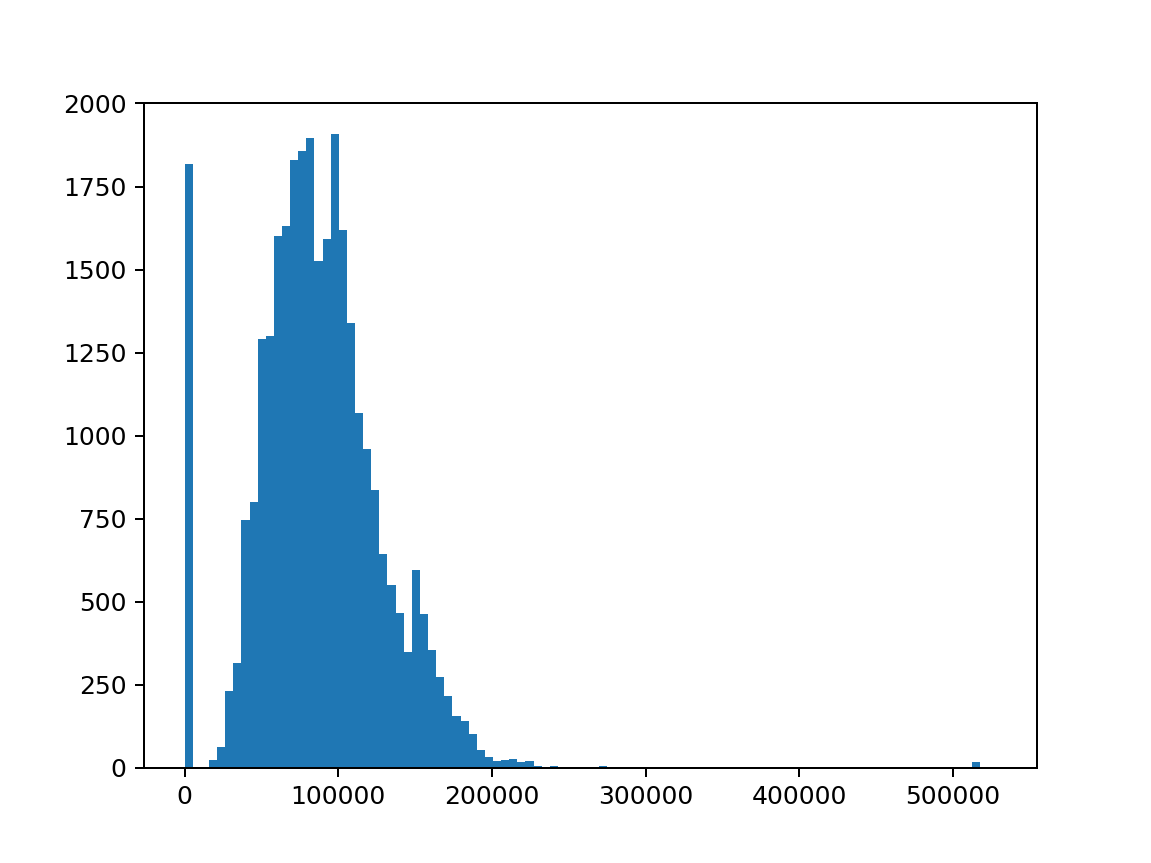

(array([1.819e+03, 1.000e+00, 2.000e+00, 2.300e+01, 6.400e+01, 2.330e+02,
        3.160e+02, 7.470e+02, 7.990e+02, 1.291e+03, 1.301e+03, 1.600e+03,
        1.630e+03, 1.830e+03, 1.856e+03, 1.895e+03, 1.525e+03, 1.591e+03,
        1.907e+03, 1.619e+03, 1.340e+03, 1.067e+03, 9.590e+02, 8.380e+02,
        6.430e+02, 5.500e+02, 4.660e+02, 3.480e+02, 5.970e+02, 4.620e+02,
        3.560e+02, 2.750e+02, 2.180e+02, 1.550e+02, 1.400e+02, 1.030e+02,
        5.300e+01, 3.400e+01, 2.200e+01, 2.500e+01, 2.600e+01, 1.800e+01,
        2.200e+01, 5.000e+00, 4.000e+00, 6.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

In [15]:
%matplotlib notebook
plt.hist(nodes.med_income_1500, bins = 100)

In [11]:
print('{} nodes have median rent zero or below'.format(len(nodes[nodes.med_rent_sqft_1500 < 0])))
print('{} nodes have median income zero or below'.format(len(nodes[nodes.med_rent_sqft_7000 <= 0])))

print('Total nodes count {}'.format(len (nodes)))

3838 nodes have median rent zero or below
647 nodes have median income zero or below
Total nodes count 30826


In [12]:
# %matplotlib notebook
# plt.hist(np.log1p(nodes.population_1500))

In [13]:
# %matplotlib notebook
# plt.hist(np.power(nodes.population_1500,1/3))